In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

# Imports
from electronTransportCode.SimOptions import LineSourceSimulation
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
from electronTransportCode.MCEstimator import FluenceEstimator
from electronTransportCode.ProjectUtils import ERE
from electronTransportCode.ParticleModel import LineSourceParticle
from electronTransportCode.ProjectUtils import E_THRESHOLD
from electronTransportCode.Material import unitDensityMaterial
%matplotlib widget

### Set up all objects

In [2]:
# Set up initial conditions
eSource: float = 1.0
SEED: int = 4  # Random number generator seed
lineSourceSim = LineSourceSimulation(minEnergy=0, eSource=eSource, rngSeed=SEED)

# Set up simulation domain
xmin = -1.0; xmax = 1.0; xbins = 100
simDomain = SimulationDomain(xmin, xmax, xmin, xmax, xbins, xbins, material=unitDensityMaterial)

# Set up dose estimator
Ebins = 10
fluenceEstimator = FluenceEstimator(simDomain=simDomain, Emin=0.0, Emax=eSource, Ebins=Ebins)

# Set up particle
particle = LineSourceParticle(generator=SEED)  # rng is later overridden by simulation object 

# Set up particle tracer
particleTracer = AnalogParticleTracer(particle=particle, simOptions=lineSourceSim, simDomain=simDomain)

### Run simulation

In [3]:
NB_PARTICLES = 10000
particleTracer(nbParticles=NB_PARTICLES, estimator=fluenceEstimator)
print(f'Average amount of events: {particleTracer.averageNbCollisions}')

Last 1000 particles took 4.198376588003157 seconds
Last 1000 particles took 4.679004867997719 seconds
Last 1000 particles took 4.449366860997543 seconds
Last 1000 particles took 5.414052473002812 seconds
Last 1000 particles took 5.025953700998798 seconds
Last 1000 particles took 3.9538433060006355 seconds
Last 1000 particles took 3.893422491997626 seconds
Last 1000 particles took 5.460145838998869 seconds
Last 1000 particles took 5.128106729000137 seconds
Last 1000 particles took 5.032421978998173 seconds
Average amount of events: 64.59930000000016


In [4]:
# Compute exact solution at E = 0 (t = 1)
import exactSolution
solRes = 101
xSolIndex = int((solRes-1)/2)
solxmax = 1.0; solxmin = -1.0
xs = np.linspace(solxmin, solxmax, solRes)
ys = np.linspace(solxmin, solxmax, solRes)
xv, yv = np.meshgrid(xs, ys)
res = np.zeros_like(xv)
for i1, x1 in enumerate(xs):
    for i2, y1 in enumerate(ys):
        if np.power(x1, 2) + np.power(y1, 2) < 1.0:
            res[i1, i2] = exactSolution.lineSourceSolution(particle.sigma, x1, y1, 0.0, eSource)


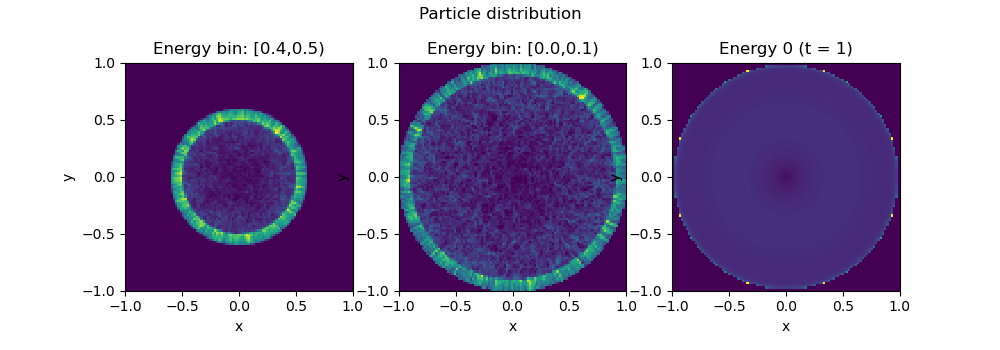

In [5]:
# Plot energy deposition
ebin2Index = 0
ebin1Index = int((Ebins-1)/2)
finalFluence = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin2Index, :], (xbins, xbins)))
initFluence = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin1Index, :], (xbins, xbins)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5))
fig.suptitle('Particle distribution')

roundDigits = 2
# Initial particle distribution
bin1left = np.round(fluenceEstimator.Erange[ebin1Index], roundDigits)
bin1right = np.round(fluenceEstimator.Erange[ebin1Index+1], roundDigits)
ax1.set_title(f'Energy bin: [{bin1left},{bin1right})')
ax1.matshow(initFluence, extent=[xmin, xmax, xmin, xmax])
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# End particle distribution
bin2left = np.round(fluenceEstimator.Erange[ebin2Index], roundDigits)
bin2right = np.round(fluenceEstimator.Erange[ebin2Index+1], roundDigits)
ax2.matshow(finalFluence, extent=[xmin, xmax, xmin, xmax])
ax2.set_title(f'Energy bin: [{bin2left},{bin2right})')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(xmin, xmax, 5))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Exact end particle distribution
ax3.matshow(res, extent=[solxmin, solxmax, solxmin, solxmax])
ax3.set_title(f'Energy 0 (t = 1)')
ax3.set_xticks(np.linspace(solxmin, solxmax, 5))
ax3.set_yticks(np.linspace(solxmin, solxmax, 5))
ax3.xaxis.tick_bottom()
ax3.set_xlabel('x')
ax3.set_ylabel('y')

plt.show()

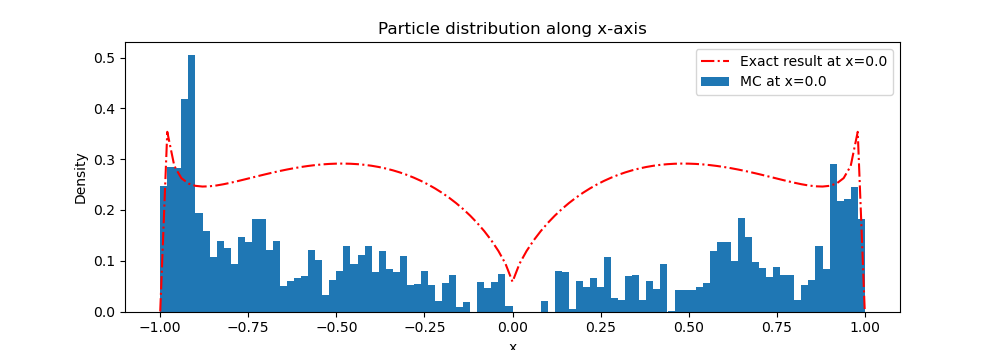

In [6]:
# End particle distribution along x-axis
ybin1Index = int((xbins)/2)

ybin1down = np.round(simDomain.yrange[ybin1Index], roundDigits)
ybin1up = np.round(simDomain.yrange[ybin1Index+1], roundDigits)

xFinalFluence = finalFluence[ybin1Index, :]
fig, ax1 = plt.subplots(figsize=(10, 3.5))
ax1.set_title('Particle distribution along x-axis')

dxMC = simDomain.xrange[1]-simDomain.xrange[0]
ax1.bar(simDomain.xrange[:-1], xFinalFluence, align='edge', width=dxMC, label=f'MC at x={np.round(simDomain.xrange[ybin1Index], roundDigits)}')
ax1.plot(xs, res[xSolIndex], '-.r', label=f'Exact result at x={np.round(xs[xSolIndex], roundDigits)}')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.legend()


Two sampling strategies for the angle

In [7]:
sum(xFinalFluence/(xFinalFluence.sum()))

1.0000000000000002

(array([499., 501., 495., 485., 465., 504., 500., 510., 487., 481., 517.,
        520., 508., 552., 465., 493., 520., 485., 517., 496.]),
 array([-9.99929607e-01, -8.99949953e-01, -7.99970299e-01, -6.99990645e-01,
        -6.00010991e-01, -5.00031336e-01, -4.00051682e-01, -3.00072028e-01,
        -2.00092374e-01, -1.00112719e-01, -1.33065136e-04,  9.98465891e-02,
         1.99826243e-01,  2.99805898e-01,  3.99785552e-01,  4.99765206e-01,
         5.99744860e-01,  6.99724515e-01,  7.99704169e-01,  8.99683823e-01,
         9.99663477e-01]),
 <BarContainer object of 20 artists>)

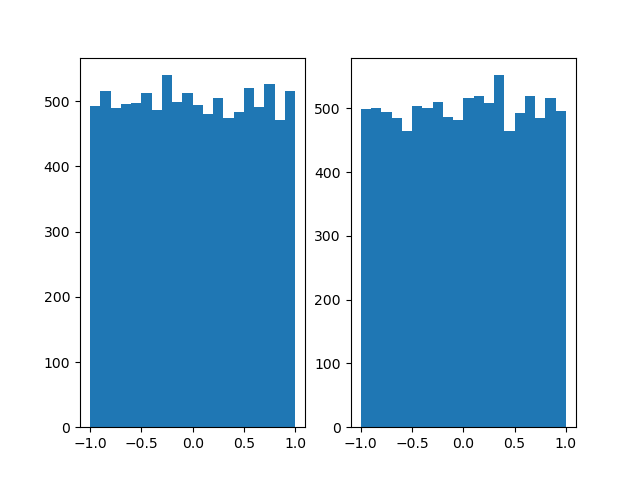

In [8]:
Nbsamples = 10000

# sample strategy 1
rs = np.random.uniform(size = Nbsamples)
theta = 2*np.arcsin(np.sqrt(rs))
mu1 = np.cos(theta)

# sample strategy 2
mu2 = np.random.uniform(low=-1, high=1, size = Nbsamples)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(mu1, bins = 20)
ax2.hist(mu2, bins = 20)